<a href="https://colab.research.google.com/github/Devanshu0502/Plant_Seedling_classification/blob/main/Plant_Seedling_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install split-folders

In [3]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

### Defining the path for test and train data

In [4]:
import splitfolders

input_folder = '/content/drive/MyDrive/Projects/NonsegmentedV2'
output_folder = '/content/dataset'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .0, .2))

Copying files: 5539 files [01:23, 66.47 files/s] 


In [5]:
import glob

train_length = 0
test_length = 0

for name in glob.glob('/content/dataset/train/*'):
  train_length += len(glob.glob(name+'/*.png'))

for name in glob.glob('/content/dataset/test/*'):
  test_length += len(glob.glob(name+'/*.png'))

print(train_length,test_length)

4426 1113


### Load using keras.preprocessing

### Creating the dataset

In [6]:
batch_size = 32
img_height = 120
img_width = 120

In [7]:
data_dir_train = '/content/dataset/train'
data_dir_test = '/content/dataset/test'

In [8]:
# creating train dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="training", seed=123,
                                                               image_size=(img_height, img_width), batch_size=batch_size)

Found 4426 files belonging to 12 classes.
Using 3541 files for training.


In [9]:
# creating validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="validation", seed=123,
                                                             image_size=(img_height, img_width), batch_size=batch_size)

Found 4426 files belonging to 12 classes.
Using 885 files for validation.


In [10]:
# Listing out all the classes of plant seedlings and store them in a list.

labels = sorted(os.listdir(data_dir_train))
print(labels)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherd’s Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [11]:
# creating a list which counts the number of images in each class of plant seedling
count_plot = []
for i in labels:
    count_plot.append(len(os.listdir(os.path.join(data_dir_train,i))))

In [12]:
count_plot

[247, 361, 268, 570, 202, 430, 609, 205, 485, 219, 460, 370]

### Visualizing the data

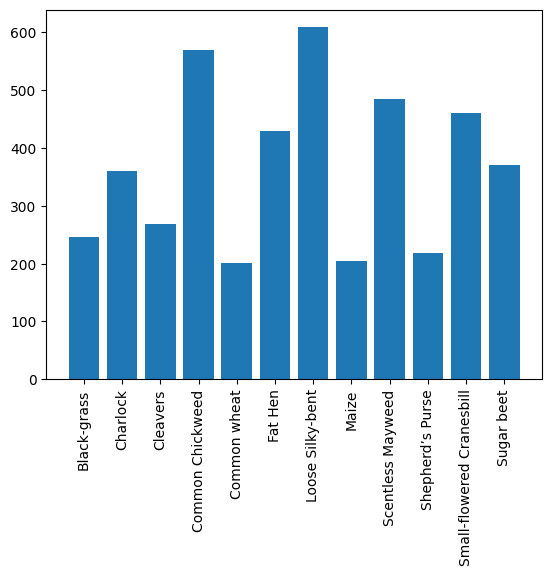

In [13]:
# creating plot for distribution of images in each class
count_plot = np.array(count_plot)
plt.bar(labels, count_plot)
plt.xticks(rotation = 90)
plt.show()

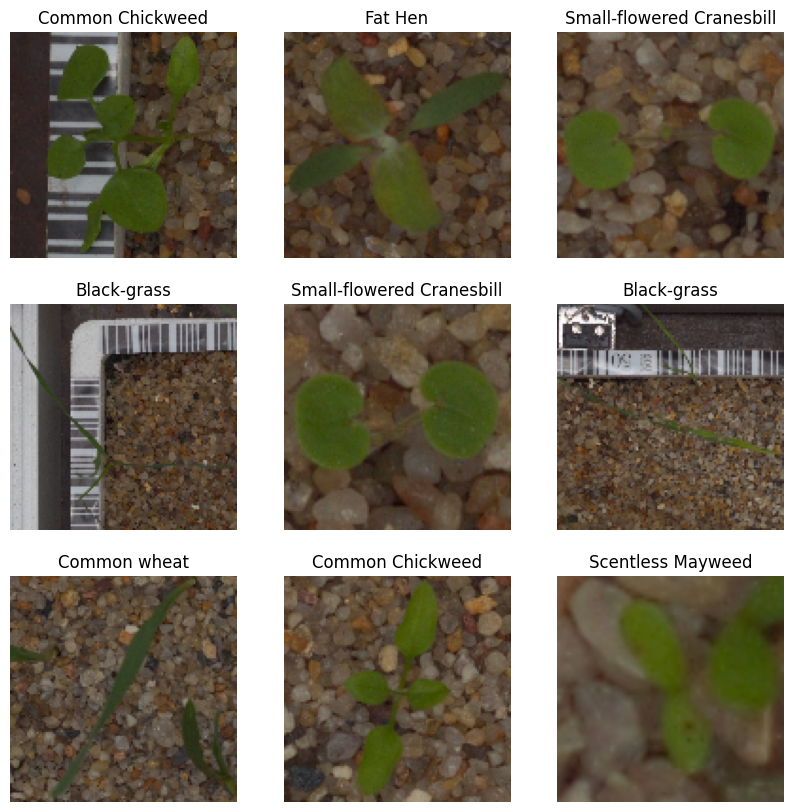

In [14]:
# visualizing few images from the train data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image, label in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(labels[label[i]])
    plt.axis("off")

## Creating the model

### Model 1
Creating a CNN model, which can accurately detect 12 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [15]:
# specifying image dimensions with RGB channel
input_shape = (120,120,3)
# storing number of classes of plant seedlings in a variable
num_classes = 12

# creating layers for the first model using conv2D
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0, input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
# using batch normalization
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [16]:
### Compiling the model
### choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
### Training the model
epochs = 20
batch_size = 32
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/20
111/111 [==============================] - 52s 310ms/step - loss: 2.9333 - accuracy: 0.4976 - val_loss: 12.9081 - val_accuracy: 0.1345
Epoch 2/20
111/111 [==============================] - 29s 247ms/step - loss: 0.8733 - accuracy: 0.7261 - val_loss: 19.2040 - val_accuracy: 0.1379
Epoch 3/20
111/111 [==============================] - 30s 261ms/step - loss: 0.5274 - accuracy: 0.8249 - val_loss: 23.9331 - val_accuracy: 0.1254
Epoch 4/20
111/111 [==============================] - 28s 243ms/step - loss: 0.3432 - accuracy: 0.8825 - val_loss: 8.9269 - val_accuracy: 0.1966
Epoch 5/20
111/111 [==============================] - 28s 244ms/step - loss: 0.2661 - accuracy: 0.9119 - val_loss: 1.8395 - val_accuracy: 0.5853
Epoch 6/20
111/111 [==============================] - 28s 243ms/step - loss: 0.2741 - accuracy: 0.9125 - val_loss: 1.6530 - val_accuracy: 0.6802
Epoch 7/20
111/111 [==============================] - 29s 245ms/step - loss: 0.2060 - accuracy: 0.9302 - val_loss: 1.0083 - val

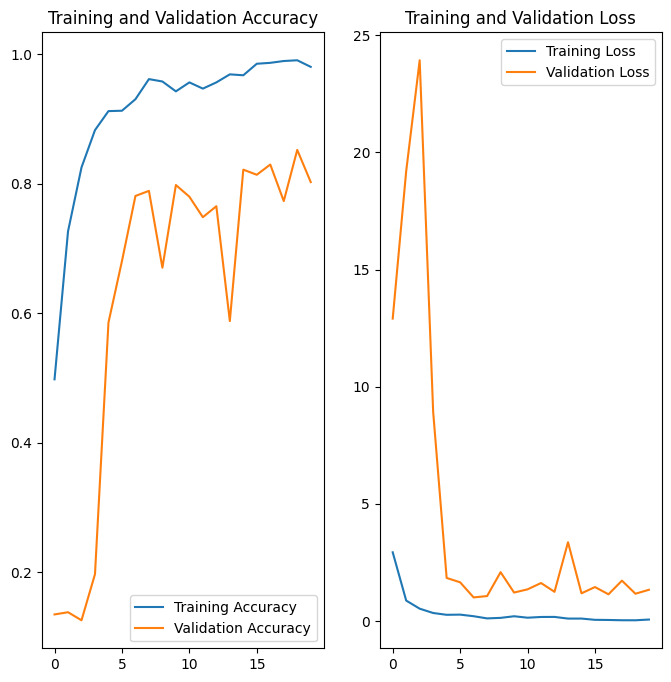

In [18]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Results from Model 1
1. The accuracy of the model for the Training data set is at 98%. But the Validation accuracy is not in par with the training accuracy.
It is only at 69%.
2. The validation loss as observed is very high.This could also be indicative of some Overfitting in the model.
3. We could add some Dropout layers and remove the BatchNormalization layers to avoid overfitting to some extent

### Model 2
#### Removing Batch Normalization and Adding Dropouts.
Removing Batch Normalization for this layer and adding dropouts after every hidden layer to avoid overfitting

In [19]:
input_shape = (120,120,3)
num_classes = 12

model2 = Sequential()
# adding layers for normalizing the images between 0 and 1
model2.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0, input_shape=input_shape))
model2.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(32, kernel_size=(3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.20))

model2.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.20))

model2.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.20))

model2.add(Flatten())
model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(Dropout(0.20))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

In [20]:
### compiling the model
### choosing an appropirate optimiser and loss function
opt = Adam(0.001) # specifying the optimizer used for the model
model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
# specifying the format in which model needs to be saved
model_name = 'Seed2' + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

callbacks_list = [checkpoint, early_stopping]

In [22]:
### training the model and using callback parameter to save the best model
epochs = 50
batch_size = 32
history = model2.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/50
110/111 [============================>.] - ETA: 0s - loss: 2.3009 - accuracy: 0.1960
Epoch 1: val_loss improved from inf to 1.63564, saving model to Seed2/model-00001-2.29759-1.63564-.h5
111/111 [==============================] - 31s 237ms/step - loss: 2.2976 - accuracy: 0.1971 - val_loss: 1.6356 - val_accuracy: 0.4373
Epoch 2/50
111/111 [==============================] - ETA: 0s - loss: 1.5174 - accuracy: 0.4696
Epoch 2: val_loss improved from 1.63564 to 1.47256, saving model to Seed2/model-00002-1.51736-1.47256-.h5
111/111 [==============================] - 28s 238ms/step - loss: 1.5174 - accuracy: 0.4696 - val_loss: 1.4726 - val_accuracy: 0.4791
Epoch 3/50
110/111 [============================>.] - ETA: 0s - loss: 1.0934 - accuracy: 0.6205
Epoch 3: val_loss improved from 1.47256 to 0.93489, saving model to Seed2/model-00003-1.09032-0.93489-.h5
111/111 [==============================] - 28s 239ms/step - loss: 1.0903 - accuracy: 0.6216 - val_loss: 0.9349 - val_accuracy: 0.6

#### Results from Model 2
1. The model is performing better than the previous model since there is comparatively less overfitting.
2. Training accuracy of 96% and validation accuracy of 78%.
3. Early Stopping used.
4. Validation loss improved from 2.25 to 1.13

## Model 3
#### Creating a model using data augmetation
1. layers.experimental.preprocessing.RandomFlip() - A preprocessing layer which randomly flips images during training.
2. layers.experimental.preprocessing.RandomRotation() - A preprocessing layer which randomly rotates images during training.

In [23]:
input_shape = (120,120,3)
num_classes = 12

model_aug = Sequential()
# scaling the images
model_aug.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0))
#layers.experimental.preprocessing.RandomFlip() - A preprocessing layer which randomly flips images during training.
#layers.experimental.preprocessing.RandomRotation() - A preprocessing layer which randomly rotates images during training.
model_aug.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
model_aug.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))
model_aug.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(Conv2D(32, kernel_size=(3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
# adding dropout layer after each Maxpooling layer
model_aug.add(Dropout(0.20))

model_aug.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(Conv2D(64, (3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Dropout(0.20))

model_aug.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(Conv2D(128, (3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Dropout(0.20))

model_aug.add(Flatten())
model_aug.add(Dense(512))
model_aug.add(Activation('relu'))
model_aug.add(Dropout(0.20))
model_aug.add(Dense(num_classes))
model_aug.add(Activation('softmax'))

In [24]:
### compiling the augmented model
### choosing an appropirate optimiser and loss function

opt = Adam(0.001)
model_aug.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# spefying the format in which model needs to be saved
model_name = 'Seed3' + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

callbacks_list = [checkpoint, early_stopping]

In [26]:
### training the model
epochs = 100
batch_size = 32
history = model_aug.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, shuffle=True)

Epoch 1/100
110/111 [============================>.] - ETA: 0s - loss: 2.4442 - accuracy: 0.1287
Epoch 1: val_loss improved from inf to 2.41359, saving model to Seed3/model-00001-2.44424-2.41359-.h5
111/111 [==============================] - 33s 243ms/step - loss: 2.4442 - accuracy: 0.1285 - val_loss: 2.4136 - val_accuracy: 0.1379
Epoch 2/100
110/111 [============================>.] - ETA: 0s - loss: 2.4246 - accuracy: 0.1301
Epoch 2: val_loss did not improve from 2.41359
111/111 [==============================] - 27s 226ms/step - loss: 2.4247 - accuracy: 0.1293 - val_loss: 2.4139 - val_accuracy: 0.1379
Epoch 3/100
110/111 [============================>.] - ETA: 0s - loss: 2.4228 - accuracy: 0.1389
Epoch 3: val_loss improved from 2.41359 to 2.41201, saving model to Seed3/model-00003-2.42301-2.41201-.h5
111/111 [==============================] - 33s 284ms/step - loss: 2.4230 - accuracy: 0.1389 - val_loss: 2.4120 - val_accuracy: 0.1379
Epoch 4/100
110/111 [============================>.]

#### Results from Model 3
1. Including Data Augmentation has improved the model accuracy to 94% and also handled overfitting to great extent.
2. Data Augmentation has improved the model performance.
3. Validation loss have improved from 1.13 to 0.29

## Model 4

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
### defining the path for training and test images
train_path = "/content/dataset/train/"
test_path = "/content/dataset/test/"

In [28]:
### distibution of classes for each category of data
### It can be seen that data has imbalances in the class distribution
for i in labels:
    directory =train_path + i + '/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.png')))
    print(f'{i} has {length} samples.')

Black-grass has 247 samples.
Charlock has 361 samples.
Cleavers has 268 samples.
Common Chickweed has 570 samples.
Common wheat has 202 samples.
Fat Hen has 430 samples.
Loose Silky-bent has 609 samples.
Maize has 205 samples.
Scentless Mayweed has 485 samples.
Shepherd’s Purse has 219 samples.
Small-flowered Cranesbill has 460 samples.
Sugar beet has 370 samples.


In [29]:
# You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes
# so that none of the classes have very few samples.
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [30]:
path_to_training_dataset=train_path

import Augmentor
for i in labels:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 247 image(s) found.
Output directory set to /content/dataset/train/Black-grass/output.

Processing <PIL.Image.Image image mode=RGB size=212x212 at 0x7C42D5FF7F40>: 100%|██████████| 500/500 [02:26<00:00,  3.42 Samples/s]


Initialised with 361 image(s) found.
Output directory set to /content/dataset/train/Charlock/output.

Processing <PIL.Image.Image image mode=RGB size=165x165 at 0x7C42D5F9F670>: 100%|██████████| 500/500 [01:00<00:00,  8.32 Samples/s]


Initialised with 268 image(s) found.
Output directory set to /content/dataset/train/Cleavers/output.

Processing <PIL.Image.Image image mode=RGB size=331x331 at 0x7C4350017C40>: 100%|██████████| 500/500 [00:31<00:00, 16.10 Samples/s]


Initialised with 570 image(s) found.
Output directory set to /content/dataset/train/Common Chickweed/output.

Processing <PIL.Image.Image image mode=RGB size=99x99 at 0x7C42D5F7B820>: 100%|██████████| 500/500 [00:21<00:00, 23.13 Samples/s]


Initialised with 202 image(s) found.
Output directory set to /content/dataset/train/Common wheat/output.

Processing <PIL.Image.Image image mode=RGB size=726x726 at 0x7C4303FE4C70>: 100%|██████████| 500/500 [01:09<00:00,  7.22 Samples/s]


Initialised with 430 image(s) found.
Output directory set to /content/dataset/train/Fat Hen/output.

Processing <PIL.Image.Image image mode=RGB size=154x154 at 0x7C42D5F4E080>: 100%|██████████| 500/500 [00:31<00:00, 15.67 Samples/s]


Initialised with 609 image(s) found.
Output directory set to /content/dataset/train/Loose Silky-bent/output.

Processing <PIL.Image.Image image mode=RGB size=88x88 at 0x7C42D5E679D0>: 100%|██████████| 500/500 [01:08<00:00,  7.30 Samples/s]


Initialised with 205 image(s) found.
Output directory set to /content/dataset/train/Maize/output.

Processing <PIL.Image.Image image mode=RGB size=1329x1329 at 0x7C43500AE680>: 100%|██████████| 500/500 [01:39<00:00,  5.04 Samples/s]


Initialised with 485 image(s) found.
Output directory set to /content/dataset/train/Scentless Mayweed/output.

Processing <PIL.Image.Image image mode=RGB size=542x542 at 0x7C42D5EAAB90>: 100%|██████████| 500/500 [00:21<00:00, 23.67 Samples/s]


Initialised with 219 image(s) found.
Output directory set to /content/dataset/train/Shepherd’s Purse/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=168x168 at 0x7C42D5E667A0>: 100%|██████████| 500/500 [00:35<00:00, 14.10 Samples/s]


Initialised with 460 image(s) found.
Output directory set to /content/dataset/train/Small-flowered Cranesbill/output.

Processing <PIL.Image.Image image mode=RGB size=113x113 at 0x7C42D5F22C80>: 100%|██████████| 500/500 [00:41<00:00, 11.97 Samples/s]


Initialised with 370 image(s) found.
Output directory set to /content/dataset/train/Sugar beet/output.

Processing <PIL.Image.Image image mode=RGB size=310x310 at 0x7C42D5E71150>: 100%|██████████| 500/500 [01:38<00:00,  5.09 Samples/s]


In [31]:
### Distribution of classes after augmentation
for i in labels:
    directory =train_path+i+'/'
    directory_out =train_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.png')))
    length_out=len(list(class_directory_out.glob('*.png')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

Black-grass has 747 samples.
Charlock has 861 samples.
Cleavers has 768 samples.
Common Chickweed has 1070 samples.
Common wheat has 702 samples.
Fat Hen has 930 samples.
Loose Silky-bent has 1109 samples.
Maize has 705 samples.
Scentless Mayweed has 985 samples.
Shepherd’s Purse has 719 samples.
Small-flowered Cranesbill has 960 samples.
Sugar beet has 870 samples.


In [32]:
batch_size = 32
img_height = 120
img_width = 120

In [33]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10426 files belonging to 12 classes.
Using 8341 files for training.


In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10426 files belonging to 12 classes.
Using 2085 files for validation.


In [35]:
input_shape = (120,120,3)
num_classes = 12

model4 = Sequential()
model4.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0))
model4.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(32, kernel_size=(3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(64, (3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(128, (3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Flatten())
model4.add(Dense(256))
model4.add(Activation('relu'))
model4.add(Dropout(0.25))
model4.add(Dense(num_classes))
model4.add(Activation('softmax'))

In [36]:
### choosing an appropirate optimiser and loss function
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
# spefying the format in which model needs to be saved
model_name = 'Seed4' + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=5, verbose=1, mode='max', min_lr=1e-5)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

callbacks_list = [checkpoint, early_stopping, lr_reduce]

In [38]:
### training the model
epochs = 100
batch_size = 32
history = model4.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/100
260/261 [============================>.] - ETA: 0s - loss: 2.4784 - accuracy: 0.1078
Epoch 1: val_loss improved from inf to 2.47488, saving model to Seed4/model-00001-2.47832-2.47488-.h5
261/261 [==============================] - 85s 299ms/step - loss: 2.4783 - accuracy: 0.1079 - val_loss: 2.4749 - val_accuracy: 0.0988 - lr: 0.0010
Epoch 2/100
261/261 [==============================] - ETA: 0s - loss: 2.4746 - accuracy: 0.1056
Epoch 2: val_loss improved from 2.47488 to 2.47400, saving model to Seed4/model-00002-2.47456-2.47400-.h5
261/261 [==============================] - 80s 301ms/step - loss: 2.4746 - accuracy: 0.1056 - val_loss: 2.4740 - val_accuracy: 0.0988 - lr: 0.0010
Epoch 3/100
261/261 [==============================] - ETA: 0s - loss: 2.4739 - accuracy: 0.1078
Epoch 3: val_loss improved from 2.47400 to 2.47394, saving model to Seed4/model-00003-2.47385-2.47394-.h5
261/261 [==============================] - 79s 297ms/step - loss: 2.4739 - accuracy: 0.1078 - val_los

#### Analysis of the result from Model 4
- Accuracy on validation data has increased to around 96% by using Augmentor library of Python
- Model is much less overfitting compared to previous models
- The above model can be further improved by tuning the hyperparameters.
- Validation loss is also less = 0.38